<a href="https://colab.research.google.com/github/bjd39/lupi-ndp/blob/main/LUPI_NDP_example_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchdiffeq

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

from torchdiffeq import odeint

import numpy as np
import random
import copy

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    !nvidia-smi
else:
    device = torch.device('cpu')
    print(f'GPU not attached to session, using device := {device}')

Thu Jun 24 09:29:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dampled coupled oscillators
The `OscillatorsDataset` produces trajectory samples from a system of damped coupled oscillators. A pair of point masses are connected by springs between opposing walls in the chain: wall-spring-mass-spring-mass-spring-wall.

`|--o--o--|`

The equations of motion are

$$
m_1\ddot{x_1} = k\cdot(x_2 - 2x_1) - c\dot{x_1} \\
m_2\ddot{x_2} = k\cdot(x_1 - 2x_2) - c\dot{x_2}
$$

where $m_i$ is the mass of the $i$-th mass, $x_i$ is the displacement of the $i$-th mass from the equilibrium position, $k$ is the spring constant, $c$ is the drag constant, and dots indicate time-derivatives.

In [4]:
class OscillatorsDataset(Dataset):
    """
    Dampled Coupled Oscillators synthetic dataset.
    
    Produces data for the system
    
    |-spring-mass-spring-mass-spring-| w/ 'air' resistance
    
    where | are walls (i.e. immovable boundaries), described by
    
    f_i = k*(x_j - 2*x_i) - c*v_i
    
    for force f, displacements x, and velocity v, using Euler integration.
    
    Parameters
        n       : int, number of samples
        dt      : float, time step
        freq    : int, how frequently to sample (multiple of dt)
        samples : int, how many samples to take (multiples of freq)
                  (an extra sample is include for t=0)
    (possible) sampling parameters
        m1,m2   : masses
        x1,x2   : initial positions
        v1,v2   : initial velocities
        k       : (ideal) spring constant
        c       : 'air' resistance constant
    If a float is provided for a sampling parameter, it is fixed at that value;
    if a list is provided, it will be uniformly sampled from the range.

    The time step, freq and samples default to
        dt      : 0.01
        freq    : 10
        samples : 10
    n defaults to 1.
    
    The 'inputs' are the sampled parameters, i.e. if only the initial
    positions are left unspecified and the 'outputs' are the positions
    over time (x1(t),x2(t)).
    
    Output times are normalised to run 0 to 1, such that the first sample
    is always at time = 0 and the final is always at time = 1.
    """
    
    def __init__(self, config, train=True, verbose=True):

        # from config
        #   base simulator setup
        self.dt = config['simulator']['dt']
        self.freq = config['simulator']['sampling_freq']
        self.samples = config['simulator']['samples']
        #   system parameter dictionaries
        self.fixed = config['fixed']
        if train:
            self.varying = config['varying']
            self.n = config['train_examples']
        else:
            self.varying = config['eval_varying']
            self.n = config['eval_examples']
        
        # + 1 for the extra sample at t = 0
        self.total_steps = self.freq*self.samples + 1
        # normalised times
        self.times = torch.arange(0,self.samples+1,1)/(1.*self.samples)
        
        if verbose:
            if train:
                print('Training data generation...')
            else:
                print('Evaluation data generation...')
            print('Fixed paramters', self.fixed)
            print('Varying parameters', self.varying)
        
        self.data = []
        # generate data
        for _ in range(self.n):
            description, conditions = self.description_and_conditions()
            output = self.single_run(conditions)
            self.data.append((description, output, self.times))
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.n
    
    def description_and_conditions(self):
        """
        Return a sample of initial conditions, with those specified at
        input being fixed and the unspecified being the description, too.
        """
        
        conditions = copy.deepcopy(self.fixed)
        for key in self.varying:
            if key in conditions:
                warnings.warn('System parameter defined in both fixed and varying configs')
            low = min(self.varying[key])
            high = max(self.varying[key])
            conditions[key] = np.random.uniform(low,high)
        
        # the description is the varying part
        description = [conditions[v] for v in self.varying]
        
        return torch.FloatTensor(description), conditions
    
    def single_run(self, conditions):
        x1, x2 = conditions['x1'], conditions['x2']
        v1, v2 = conditions['v1'], conditions['v2']
        m1, m2 = conditions['m1'], conditions['m2']
        c, k = conditions['c'], conditions['k']
        output = []
        for step in range(self.total_steps):
            if step % self.freq == 0:
                output.append([x1,x2])
            
            a1 = k*(x2-2*x1) - c*v1
            a2 = k*(x1-2*x2) - c*v2
            
            x1 += self.dt*v1
            x2 += self.dt*v2
            v1 += self.dt*a1
            v2 += self.dt*a2
    
        return torch.FloatTensor(output)

A distribution over dynamics can be generated by varying the initial conditions, i.e. $x_i(0), \dot{x_i}(0)$, and/or the masses $m_i$, spring stiffness $k$, or drag coefficient $c$.

The trajectories are sampled according to the parameters `dt`, `freq` and `samples`: `dt` is the unit time for the underlying simulator which uses Euler integration; `freq` sets how many steps (in `dt`) are skipped between samples; `samples` sets how many samples to take total (with an extra sample taken at `t=0`.) For example, with

```
dt = 0.001
freq = 100
samples = 20
```

the simulator takes steps of `0.001`, the time between samples is `dt*freq = 0.1` and there are 20 samples total (`0, 0.1, 0.2, ..., 2.0`). The times are then normalised to always run from 0 to 1, so these settings will result in samples being taken at (`0, 0.05, 0.1, 0.15, ..., 1.0`).

**For example**, this plot shows trajectories sampled by varying the spring stiffness.

Training data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'x1': 1, 'x2': -1, 'v1': 0, 'v2': 0, 'c': 1}
Varying parameters {'k': [0.2, 1.0]}


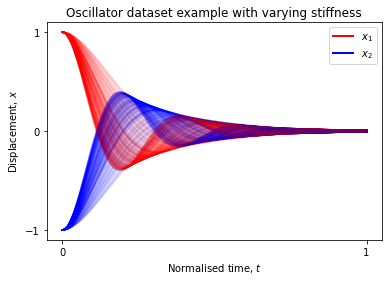

In [5]:
data_config = {
    'train_examples' : 500,
    'train_val_split' : 0.8,
    'eval_examples' : 100,
    'simulator' : {
        'dt' : 0.01,
        'sampling_freq' : 5,
        'samples' : 200
    },
    'fixed' : {
        'm1' : 1,
        'm2' : 1,
        'x1' : 1,
        'x2' : -1,
        'v1' : 0,
        'v2' : 0,
        'c' : 1
    },
    'varying' : {
        'k' : [0.2, 1.]
    },
    'eval_varying' : {
        'k' : [0.2, 1.]
    }
}

# generate a dataset
example_set = OscillatorsDataset(data_config)
example_loader = DataLoader(example_set, batch_size=1)

# sanity plot
for inputs, labels, times in example_loader:
    plt.plot(times[0], labels[0,:,0], alpha=0.03, c='r')
    plt.plot(times[0], labels[0,:,1], alpha=0.03, c='b')
plt.title('Oscillator dataset example with varying stiffness')
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]
plt.legend(custom_lines, ['$x_1$', '$x_2$'])
plt.yticks([-1,0,1])
plt.xticks([0,1])
plt.xlabel('Normalised time, $t$')
plt.ylabel('Displacement, $x$')
plt.show()

# Models

## Model components
The LUPI-NDP and NDP are built from the same modules. The only difference is during training where the LUPI model uses privileged information in the forward pass (enabled with a residual connection.)

In [6]:
class obs_encoder(nn.Module):
    """
    Takes raw observations (x_i, t_i) and produces a representation r_i.
    """
    
    def __init__(self,config):
        super(obs_encoder, self).__init__()
        
        obs_dim = config['x_dim']
        h_dim = config['obs_enc_h_dim']
        r_dim = config['r_dim']
        
        layers = [
            nn.Linear(obs_dim+1,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,r_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
    
    def forward(self, observations, times):
        return self.layers(torch.cat([observations, times.unsqueeze(-1)],-1))

class pi_encoder(nn.Module):
    """
    Takes the privileged information signal and produces a representation r_p.
    """
    def __init__(self, config):
        super(pi_encoder, self).__init__()
        
        pi_dim = config['pi_dim']
        h_dim = config['pi_enc_h_dim']
        r_dim = config['pi_r_dim']
        
        layers = [
            nn.Linear(pi_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,r_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class r_aggregator(nn.Module):
    """
    Takes mixed representations from observations and privileged information and
    produces a single task representation.
    
    In evaluation mode privileged information should not be used and a warning will
    given if this is attempted.
    """
    def __init__(self, config):
        super(r_aggregator, self).__init__()
        
        obs_r_dim = config['r_dim']
        pi_r_dim = config['pi_r_dim']
        h_dim = config['agg_h_dim']
        
        self.aggregators = config['aggregators']
        
        for agg in self.aggregators:
            if agg not in ['mean','max','min','logsumexp']:
                raise ValueError(f'Aggregator {agg} is not supported.')
        
        # when using privileged information we combine the representations with a small ResNet
        layers = [
            nn.Linear(obs_r_dim*len(self.aggregators)+pi_r_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,obs_r_dim*len(self.aggregators))
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
    def aggregate(self, obs_r):
        # concatentate the aggregator outputs
        agg = []
        if 'max' in self.aggregators:
            agg.append(torch.max(obs_r,0).values)
        if 'min' in self.aggregators:
            agg.append(torch.min(obs_r,0).values)
        if 'logsumexp' in self.aggregators:
            agg.append(torch.logsumexp(obs_r,0))
        if 'mean' in self.aggregators:
            agg.append(torch.mean(obs_r,0))
        
        return torch.cat(agg, 0)
        
    def forward(self, r_i, r_p=None):
        if not self.training and r_p is not None:
            warnings.warn('Privileged information provided to the aggregator in evaluation mode.')
        
        # aggregate observations
        r_obs = self.aggregate(r_i)
        
        # if we have privileged information, use the resnet
        # r_obs' = r_obs + f(r_obs, r_p)
        if r_p is not None:
            r_obs = r_obs + self.layers(torch.cat([r_obs, r_p], -1))
        
        return r_obs

class r_to_z(nn.Module):
    """
    From task representation to global latent variable.
    """
    def __init__(self, config):
        super(r_to_z, self).__init__()
        
        aggregated_r_dim = config['r_dim'] * len(config['aggregators'])
        h_dim = config['r_to_z_h_dim']
        z_dim = config['z_dim']
        
        layers = [
            nn.Linear(aggregated_r_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU()
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
        self.h_to_mu = torch.nn.Linear(h_dim, z_dim)
        self.h_to_sigma = torch.nn.Linear(h_dim, z_dim)
        
    def forward(self, r):
        h = self.layers(r)
        mu = self.h_to_mu(h)
        sigma = 0.1 + 0.9*torch.sigmoid(self.h_to_sigma(h))
        
        return Normal(mu, sigma)

class z_to_L0(nn.Module):
    """
    Use a sample from the global latent variable to produce the initial L value.
    """
    def __init__(self,config):
        super(z_to_L0, self).__init__()
        
        L_dim = config['L_dim']
        z_dim = config['z_dim']
        h_dim = config['z_to_L_h_dim']
        
        layers = [
            nn.Linear(z_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,L_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
    def forward(self, z_sample):
        return self.layers(z_sample)

class conditional_ODE_func(nn.Module):
    """
    Conditional derivative function.
    
    Input is a concatentation of the ODE latent state and the global latent variable sample,
    and the time
        (L || z, t)
    Output is the derivative at that time
        (dL || dz)
    with dz set to 0.
    
    This is a 'hacky' way to condition the ODE without letting the sample varying.
    """
    
    def __init__(self,config):
        super(conditional_ODE_func, self).__init__()
        
        L_dim = config['L_dim']
        z_dim = config['z_dim']
        h_dim = config['ode_h_dim']
        
        layers = [
            torch.nn.Linear(L_dim+z_dim+1,h_dim),
            torch.nn.Softplus(),
            torch.nn.Linear(h_dim,h_dim),
            torch.nn.Softplus(),
            torch.nn.Linear(h_dim,L_dim)
        ]
        
        self.latent_func = torch.nn.Sequential(*layers)
        
        self.L_dim = L_dim
        
        self.nfe = 0
    
    def forward(self, t, L_z):
        self.nfe += 1
        z = L_z[self.L_dim:]
        L_z_t = torch.cat([L_z,t.unsqueeze(-1)])
        dL = self.latent_func(L_z_t)
        dz = torch.zeros_like(z)
        
        return torch.cat([dL,dz])

class decoder(nn.Module):
    """
    Produce an output from the ODE latent state and the global latent variable sample.
    """
    def __init__(self, config):
        super(decoder, self).__init__()
        
        L_dim = config['L_dim']
        z_dim = config['z_dim']
        h_dim = config['dec_h_dim']
        out_dim = config['x_dim']
        
        layers = [
            torch.nn.Linear(L_dim+z_dim,h_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(h_dim,h_dim),
            torch.nn.ReLU()
        ]
        
        self.shared_layers = torch.nn.Sequential(*layers)
        
        self.hidden_to_mu = torch.nn.Linear(h_dim, out_dim)
        self.hidden_to_sigma = torch.nn.Linear(h_dim, out_dim)
        
    def forward(self, L_z_t):
        
        hidden = self.shared_layers(L_z_t)
        mu = self.hidden_to_mu(hidden)
        sigma = 0.1 + 0.9*F.softplus(self.hidden_to_sigma(hidden))
        return Normal(mu, sigma)

## Architectures
The modules are combined into full models: `LUPI_NDP` and `NDP`.

In [7]:
class LUPI_NDP(nn.Module):
    
    def __init__(self, config):

        super(LUPI_NDP, self).__init__()
        
        self.observations_encoder = obs_encoder(config)
        self.privileged_info_encoder = pi_encoder(config)
        self.representation_aggregator = r_aggregator(config)
        self.representation_to_global_latent = r_to_z(config)
        self.global_latent_to_initial_value = z_to_L0(config)
        self.odefunc = conditional_ODE_func(config)
        self.decoder = decoder(config)
        
    def forward(self, observations, times, p_info, context_idx, target_idx):
        if self.training:
            # encode
            r_i = self.observations_encoder(observations, times)
            r_p = self.privileged_info_encoder(p_info)
            # aggregate
            r_C = self.representation_aggregator(r_i[context_idx],None)
            r_T = self.representation_aggregator(r_i[target_idx],r_p)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            z_T = self.representation_to_global_latent(r_T)
            # sample (from target Z during training)
            z_ = z_T.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx])
            return z_C, z_T, self.decoder(L_z_t)
        
        else:
            # encode
            r_i = self.observations_encoder(observations[context_idx],
                                            times[context_idx])
            # aggregate
            r_C = self.representation_aggregator(r_i,None)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            # sample (from context Z during eval.)
            z_ = z_C.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx].squeeze())
            return self.decoder(L_z_t)

class NDP(nn.Module):
    """
    No privileged information NDP model built to sub in directly for the LUPI
    model for the sake of experimental consistency. Primarily this means that
    the forward pass takes a 'p_info' argument despite not using it.
    """
    
    def __init__(self, config):

        super(NDP, self).__init__()
        
        self.observations_encoder = obs_encoder(config)
        self.representation_aggregator = r_aggregator(config)
        self.representation_to_global_latent = r_to_z(config)
        self.global_latent_to_initial_value = z_to_L0(config)
        self.odefunc = conditional_ODE_func(config)
        self.decoder = decoder(config)
        
    def forward(self, observations, times, p_info, context_idx, target_idx):
        if self.training:
            # encode
            r_i = self.observations_encoder(observations, times)
            # aggregate (no PI so both aggregate without it)
            r_C = self.representation_aggregator(r_i[context_idx],None)
            r_T = self.representation_aggregator(r_i[target_idx],None)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            z_T = self.representation_to_global_latent(r_T)
            # sample (from target Z during training)
            z_ = z_T.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx])
            return z_C, z_T, self.decoder(L_z_t)
        
        else:
            # encode
            r_i = self.observations_encoder(observations[context_idx],
                                            times[context_idx])
            # aggregate
            r_C = self.representation_aggregator(r_i,None)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            # sample (from context Z during eval.)
            z_ = z_C.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx].squeeze())
            return self.decoder(L_z_t)

# Training

## `config`
The model, dataset, training and evaluation are all defined from a config file.

In [8]:
config = {
    'model' : 'lupi', # lupi or nopi
    # data stuff
    'train_examples' : 500,
    'train_val_split' : 0.8,
    'eval_examples' : 100,
    'simulator' : {
        'dt' : 0.01,
        'sampling_freq' : 20,
        'samples' : 50
    },
    'fixed' : {
        'm1' : 1,
        'm2' : 1,
        'x1' : 1,
        'x2' : -1,
        'v1' : 0,
        'v2' : 0,
        'c' : 1
    },
    'varying' : {
        'k' : [0.2, 1.]
    },
    'eval_varying' : {
        'k' : [0.2, 1.]
    },
    # model stuff
    'x_dim' : 2,
    'obs_enc_h_dim' : 16,
    'r_dim': 16,
    'pi_dim': 1,
    'pi_enc_h_dim': 16,
    'pi_r_dim': 16,
    'aggregators': ['logsumexp', 'mean'],
    'agg_h_dim': 16,
    'r_to_z_h_dim': 16,
    'z_dim': 16,
    'z_to_L_h_dim': 16,
    'L_dim': 16,
    'ode_h_dim': 16,
    'dec_h_dim': 16,
    # training details
    'lr' : 1e-3,
    'epochs' : 100,
    'val_and_print' : 10,
    'context_range' : [5,10],
    'target_range' : [15,51], # superset of context
}

## Data
Generate data

In [9]:
# datasets
train_val_set = OscillatorsDataset(config)
train_set = train_val_set[:int(config['train_examples']*config['train_val_split'])]
val_set = train_val_set[int(config['train_examples']*config['train_val_split']):]
eval_set = OscillatorsDataset(config, train=False)

train_examples = len(train_set)
val_examples = len(val_set)
eval_examples = len(eval_set)

# loaders
train_loader = DataLoader(train_set, batch_size=1)
val_loader = DataLoader(val_set, batch_size=1)
eval_loader = DataLoader(eval_set, batch_size=1)

Training data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'x1': 1, 'x2': -1, 'v1': 0, 'v2': 0, 'c': 1}
Varying parameters {'k': [0.2, 1.0]}
Evaluation data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'x1': 1, 'x2': -1, 'v1': 0, 'v2': 0, 'c': 1}
Varying parameters {'k': [0.2, 1.0]}


## Model and optimizer
Define the model, optimizer and the context and target ranges used for data sampling.

In [10]:
# model and optimizer
if config['model'] == 'lupi':
    model = LUPI_NDP(config)
elif config['model'] == 'nopi':
    model = NDP(config)
else:
    print('Config model not recognised.')
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
context_range = range(min(config['context_range']),max(config['context_range']))
target_range = range(min(config['target_range']),max(config['target_range']))

Make an untrained pass to check things are as we expect

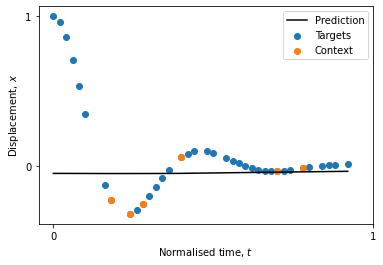

In [11]:
pi, x, times = next(iter(train_loader))

context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
target_idx = random.sample(range(config['simulator']['samples']),target_size) # a set of indices
context_idx = random.sample(target_idx, context_size) # a subset of the target indices
target_idx.sort()
context_idx.sort()
target_idx = torch.LongTensor(target_idx)
context_idx = torch.LongTensor(context_idx)

# haven't sorted out time sampled batching properly yet so squeezing out the batch dim
zC,zT,preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
plt.scatter(times.squeeze(0)[target_idx],x.squeeze(0)[target_idx][:,0], label='Targets')
plt.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0], label='Context')
plt.plot(times.squeeze(0)[target_idx],preds.loc[:,0].detach(), color='k', label='Prediction')
plt.yticks([0,1])
plt.xticks([0,1])
plt.xlabel('Normalised time, $t$')
plt.ylabel('Displacement, $x$')
plt.legend()
plt.show()

## Training loop

In [12]:
for epoch in range(config['epochs']):
    total_epoch_loss = 0
    recon_epoch_loss = 0
    kl_epoch_loss = 0
    # training loop
    for i,batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        pi, x, times = batch
        
        # context/target idx
        context_size = random.sample(context_range,1)[0]
        target_size = random.sample(target_range,1)[0]
        # during training, context are a subset of targets
        target_idx = random.sample(range(config['simulator']['samples']),target_size)
        context_idx = random.sample(target_idx, context_size)
        target_idx.sort()
        context_idx.sort()
        target_idx = torch.LongTensor(target_idx)
        context_idx = torch.LongTensor(context_idx)
        
        zC, zT, preds = model(x.squeeze(0),
                              times.squeeze(0),
                              pi.squeeze(0),
                              context_idx,
                              target_idx)

        # reconstruction term
        log_likelihood = preds.log_prob(x.squeeze(0)[target_idx]).sum()
        # kl term
        kl = kl_divergence(zT, zC).sum()
        
        loss = -log_likelihood + kl

        loss.backward()
        
        optimizer.step()
        
        total_epoch_loss += loss.item()
        recon_epoch_loss += -log_likelihood.item()
        kl_epoch_loss += kl.item()
    # validation and printing loop
    with torch.no_grad():
        if (epoch+1) % config['val_and_print'] == 0:
            model.eval()
            val_recon = 0

            for i, batch in enumerate(val_loader):
                pi, x, times = batch

                # context/target idx
                context_size = random.sample(context_range,1)[0]
                # during eval, context and targets are disjoint and targets are all but context
                context_idx = random.sample(range(config['simulator']['samples']), context_size)
                target_idx = list(set(range(config['simulator']['samples']))-set(context_idx))
                context_idx.sort()
                target_idx = torch.LongTensor(target_idx)
                context_idx = torch.LongTensor(context_idx)

                preds = model(x.squeeze(0),times.squeeze(0),pi.squeeze(0),
                              context_idx,target_idx)
                log_likelihood = preds.log_prob(x.squeeze(0)[target_idx]).mean()

                val_recon += -log_likelihood.item()
            print_string = (
                "Epoch {0:d} \t"
                "Train {1:.0f} / {2:.0f} / {3:.0f} \t"
                "Val {4:.0f}"
            ).format(epoch+1,
                     total_epoch_loss/train_examples, recon_epoch_loss/train_examples,
                     kl_epoch_loss/train_examples,val_recon/val_examples)
            print(print_string)
            model.train()

Epoch 10 	Train -67 / -70 / 3 	Val -1
Epoch 20 	Train -78 / -82 / 4 	Val -0
Epoch 30 	Train -81 / -85 / 4 	Val -0
Epoch 40 	Train -82 / -85 / 3 	Val -0
Epoch 50 	Train -83 / -86 / 3 	Val -0
Epoch 60 	Train -87 / -89 / 3 	Val -0
Epoch 70 	Train -83 / -86 / 3 	Val -1
Epoch 80 	Train -85 / -88 / 3 	Val -0
Epoch 90 	Train -82 / -85 / 3 	Val -1
Epoch 100 	Train -84 / -87 / 3 	Val -1


# Evaluation
Evaluation is run in both test and train modes i.e. `model.eval()` and `model.train()`. This determines the size of the context set for both models, and whether privileged information is used by the LUPI model. The gap between test and train mode performance shows how well the model adapts to the test-time setting.

In [13]:
z_samples = 50

with torch.no_grad():
    
    eval_error = 0.
    pi_error = 0.

    for i, batch in enumerate(eval_loader):
        # get example
        pi, x, times = batch
        
        pi_preds = []
        nopi_preds = []

        context_range = range(5,10)
        target_range = range(15,51)

        context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
        target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
        target_idx = list(range(config['simulator']['samples'])) # a set of indices
        context_idx = random.sample(target_idx, context_size) # a subset of the target indices
        target_idx.sort()
        context_idx.sort()
        target_idx = torch.LongTensor(target_idx)
        context_idx = torch.LongTensor(context_idx)
        
        for _ in range(z_samples):
            model.train()
            _,_,train_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
            pi_preds.append(train_preds.loc[:,0].detach())
            model.eval()
            eval_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
            nopi_preds.append(eval_preds.loc[:,0].detach())
        pi_mean = torch.stack(pi_preds,0).mean(0)
        eval_mean = torch.stack(nopi_preds,0).mean(0)
        
        eval_error += torch.mean((eval_mean - x.squeeze(0)[:-1,0])**2).item()
        pi_error += torch.mean((pi_mean - x.squeeze(0)[:-1,0])**2).item()

eval_error = eval_error/len(eval_loader)
pi_error = pi_error/len(eval_loader)
print(f'MSE eval: \t{eval_error:.5f}')
print(f'MSE train: \t{pi_error:.5f}')

MSE eval: 	0.00698
MSE train: 	0.00057


## Evaluation plots
`eval_iter` is defined separately such that rerunning the plotting cell uses a different example.

In [16]:
eval_iter = iter(eval_loader)
train_label = 'Using targets and PI' if config['model'] == 'lupi' else 'Using targets'
eval_label = 'Context only'

P.I. ≈ 0.75


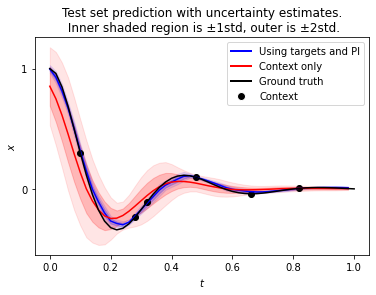

In [20]:
pi, x, times = next(eval_iter)

print(f'P.I. ≈ {pi.item():.2f}')

context_range = range(5,10)
target_range = range(15,51)

context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
target_idx = list(range(config['simulator']['samples'])) # a set of indices
context_idx = random.sample(target_idx, context_size) # a subset of the target indices
target_idx.sort()
context_idx.sort()
target_idx = torch.LongTensor(target_idx)
context_idx = torch.LongTensor(context_idx)

# sample a bunch of predictions
z_samples = 50
pi_preds = []
nopi_preds = []
for _ in range(z_samples):
    # haven't sorted out time sampled batching properly yet so squeezing out the batch dim
    model.train()
    _,_,train_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    pi_preds.append(train_preds.loc[:,0].detach())
    model.eval()
    eval_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    nopi_preds.append(eval_preds.loc[:,0].detach())
pi_mean = torch.stack(pi_preds,0).mean(0)
pi_std = torch.stack(pi_preds,0).std(0)
eval_mean = torch.stack(nopi_preds,0).mean(0)
eval_std = torch.stack(nopi_preds,0).std(0)

# plot ±2 std and ±1 std as transparent fills
plt.fill_between(times.squeeze(0)[target_idx],eval_mean+2*eval_std,eval_mean-2*eval_std, alpha = 0.1, color='r')
plt.fill_between(times.squeeze(0)[target_idx],pi_mean+2*pi_std,pi_mean-2*pi_std, alpha = 0.1, color='b')
plt.fill_between(times.squeeze(0)[target_idx],eval_mean+eval_std,eval_mean-eval_std, alpha = 0.2, color='r')
plt.fill_between(times.squeeze(0)[target_idx],pi_mean+pi_std,pi_mean-pi_std, alpha = 0.2, color='b')
# plot means over the top
plt.plot(times.squeeze(0)[target_idx],pi_mean,color='b')
plt.plot(times.squeeze(0)[target_idx],eval_mean,color='r')
# ground truth in black with context dots
plt.plot(times.squeeze(0), x.squeeze(0)[:,0], label='Ground truth', color='k')
plt.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0], label='Context',color='k')
custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], marker='o', color='w', label='Scatter',
                       markerfacecolor='k', markersize=8)]
plt.legend(custom_lines, [train_label, eval_label, 'Ground truth', 'Context'])
plt.title('Test set prediction with uncertainty estimates.\n Inner shaded region is ±1std, outer is ±2std.')
plt.yticks([-0.5,0,0.5,1])
plt.yticks([0,1])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()